# Projet Immothep

Pour nettoyer notre jeu de données nous avons tout d'abord enlevé l'ensemble des colonnes non nécessaires à nos requêtes afin de ne conserver que les colonnes utiles (La nature de la mutation, la valeur fonciere, le code postal, les surfaces des lots en loi Carrez, le type de local, le nombre de pièces principales, la surface du terrain et la surface réelle bati)

Concernant le type de local nous ne souhaitons estimer que les biens étant des appartements ou des maisons. Pour la nature de la mutation nous ne conservons que les biens ayant été mis en vente.

Pour les surfaces des lots en loi Carrez nous faisons une nouvelle colonne étant la somme des 5 lots.

Nous avons remarqué dans la documentation fournie par le site data.gouv.fr (D'où provient notre jeu de données) que la note descriptive de ce fichier nous indiquait que seuls les 5 premiers lots d'un lot plus important étaient restitués au sein du document. Pour cette raison nous avons décidé de ne pas conserver tous les lots supérieurs à 5 lots.

Concernant les surfaces des biens immobiliers restants dans notre jeu de données nous avons remarqué que les maisons ne faisaient souvent pas parties de lots et avaient donc une surface loi Carrez de 0m^2. Pour cela nous avons donc émis 3 postulats :

Postulat numéro 1
- Utiliser la surface reelle bati plutot que la surface loi Carrez car cette colonne ne contient pas de données nulles.

Postulat numéro 2
- Utiliser la surface loi Carrez (Cela aura pour conséquence d'enlever toutes les lignes ayant une valeur nulle) afin de voir si les estimations sont différentes ou égales que lorsque nous utilisons la surface réelle bati (Postulat numéro 1).

Postulat numéro 3
- Faire un regroupement des deux colonnes (Lorsque la surface loi Carrez est égale à 0 nous la remplacons par la surface réelle bati) Encore une fois nous vérifierons que nos estimations ne soient pas trop éloignées du postulat numéro 1.


Le minimum légal en France pour la superficie d'un logement étant de 9m^2 nous avons donc décidé de supprimer de notre jeu de données tous les biens immobiliers ayant une surface réelle bati inférieure à 9m^2.

Nous avons aussi enlevé de notre jeu de données les biens ayant 0 pièce principale car cela est illogique (Le minimum d'un bien étant une pièce principale).

In [33]:
# IPython extension reloading modules before user enters code.
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from functions import split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
csv = pd.read_csv("./data/RAW/valeursfoncieres-2019.txt", sep = '|', decimal = ',', usecols = ['Nature mutation', 'Valeur fonciere', 'Code postal', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Nombre de lots', 'Type local', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati'])

In [ ]:
csv = csv.dropna(subset = ['Type local'])

In [ ]:
csv = csv[['Nature mutation', 'Valeur fonciere', 'Code postal', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Nombre de lots', 'Type local', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati']][csv['Type local'].str.contains('Appartement|Maison', regex = True)]

In [ ]:
csv = csv[['Nature mutation', 'Valeur fonciere', 'Code postal', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Nombre de lots', 'Type local', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati']][csv['Nature mutation'].str.contains('Vente', regex = True)]

In [ ]:
csv["Surface Carrez totale"] = csv[['Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']].sum(axis = 1)

In [ ]:
csv = csv.drop(columns = ['Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Nature mutation', 'Type local'])

In [ ]:
csv = csv.dropna(subset = ['Code postal', 'Surface Carrez totale', 'Valeur fonciere'])

In [ ]:
csv = csv.fillna(0)

In [ ]:
csv = csv[csv["Nombre de lots"] < 6]

In [ ]:
csv = csv[csv["Surface reelle bati"] > 8]

In [ ]:
csv = csv[csv["Nombre pieces principales"] >= 1]

In [ ]:
csv.to_csv('./data/CURATED/csv_clean_1.csv')

In [ ]:
cleaned_dataframe = pd.read_csv('./data/CURATED/csv_clean_1.csv')

In [ ]:
sample_cleaned_dataframe = cleaned_dataframe.sample(n = 10000, random_state = 1)

In [ ]:
sample_cleaned_dataframe.to_csv('./data/SAMPLE/sample_1.csv')

In [16]:
df_anomaly = pd.read_csv('./data/CURATED/anomaly_csv_clean_1.csv', sep = ',', decimal = ',')

In [17]:
df_csv_clean = pd.read_csv('./data/CURATED/csv_clean_1.csv', sep = ',', decimal = ',')

In [18]:
df_anomaly = df_anomaly.drop(columns = ['Unnamed: 0'])

In [19]:
df_anomaly = df_anomaly.drop(columns = ['Valeur fonciere', 'Code postal', 'Nombre de lots', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Surface Carrez totale', 'scores'])

In [20]:
df_anomaly = df_anomaly.rename(columns = {'Unnamed: 0.1':'Unnamed: 0'})

In [21]:
df_add_anomaly = df_csv_clean.merge(df_anomaly, how = 'left', on = 'Unnamed: 0')

In [22]:
df_add_anomaly = df_add_anomaly.fillna(0)

In [23]:
df_add_anomaly = df_add_anomaly[df_add_anomaly["anomaly"] == 0]

In [24]:
df_add_anomaly = df_add_anomaly.drop(columns = ['Unnamed: 0', 'anomaly'])

In [25]:
df_add_anomaly.to_csv('./data/CURATED/csv_clean_2.csv')

In [26]:
del df_add_anomaly
del df_anomaly
del df_csv_clean

In [35]:
df_clean = pd.read_csv('./data/CURATED/csv_clean_2.csv')

In [36]:
df_clean = df_clean.drop(columns = ['Unnamed: 0'])

&lt;AxesSubplot:&gt;

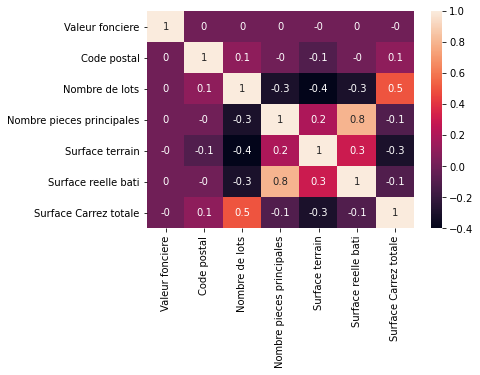

In [37]:
matrice_correlation = df_clean.corr().round(1)
sns.heatmap(data = matrice_correlation, annot = True)